# __Classifying Dark Matter Substructure with Equivariant Neural Networks: A Tutorial__

#### We start with importing the neccesary dependancies used in the code.

In [1]:
import sys
import os
import time
import logging
import argparse
import shutil
import torch
import copy
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from os import listdir
from os.path import join
import torch.optim as optim
from e2cnn import gspaces, nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### __Initializing arguments__

In [2]:
use_cuda = True # True, if use cuda
cuda_idx = 0 # Set idx of cuda device to be used, default is 0
data_dir = 'images_f' # Path of the data directory
sym_group = 'Circular' # Symmetry group to be used:{'Circular', 'Dihyderal'}
N = 4 # Order of the symmetry group
epochs = 40 # Number of Epochs
batch_size = 64 # Batch Size
lr = 5e-5 # learning rate
n_classes = 3 # Number of classes to be classified

#### __Selecting the device type to run the code__

In [3]:
def get_device(use_cuda=True, cuda_idx=0):
    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [4]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


#### __Logger to save the results__

In [5]:
def init_logging_handler(log_dir, current_time, extra=''):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True


In [6]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'Model_' + data_dir[-1] + '_' + sym_group[0]+str(N)+'_Tutorial'
init_logging_handler(log_dir, current_time)

#### __Preprocessing__

In [7]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

##### __Transforms__: Image is first randomaly cropped to have a size $128 \times 128$. It is then padded to increase the size to $129 \times 129$. Further, the image is resized to $387 \times 387$, randomly rotated and resized back to $129 \times 129$.

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(180, resample=Image.BILINEAR, expand=False),
    resize2,
    totensor,
    togray,
])
transform_test = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    totensor,
    togray,
])

#### __Dataloader__

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = [join(self.root_dir, x).split('/')[3] for x in listdir(self.root_dir)]
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = np.load(image)
        image = image / image.max() #normalizes data in range 0 - 255
        image = 255 * image
        image  = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [10]:
trainset = CustomDataset(data_dir+'/','train',transform_train)
testset = CustomDataset(data_dir+'/', 'test',transform=transform_test)

In [11]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

#### __Visualize image samples__

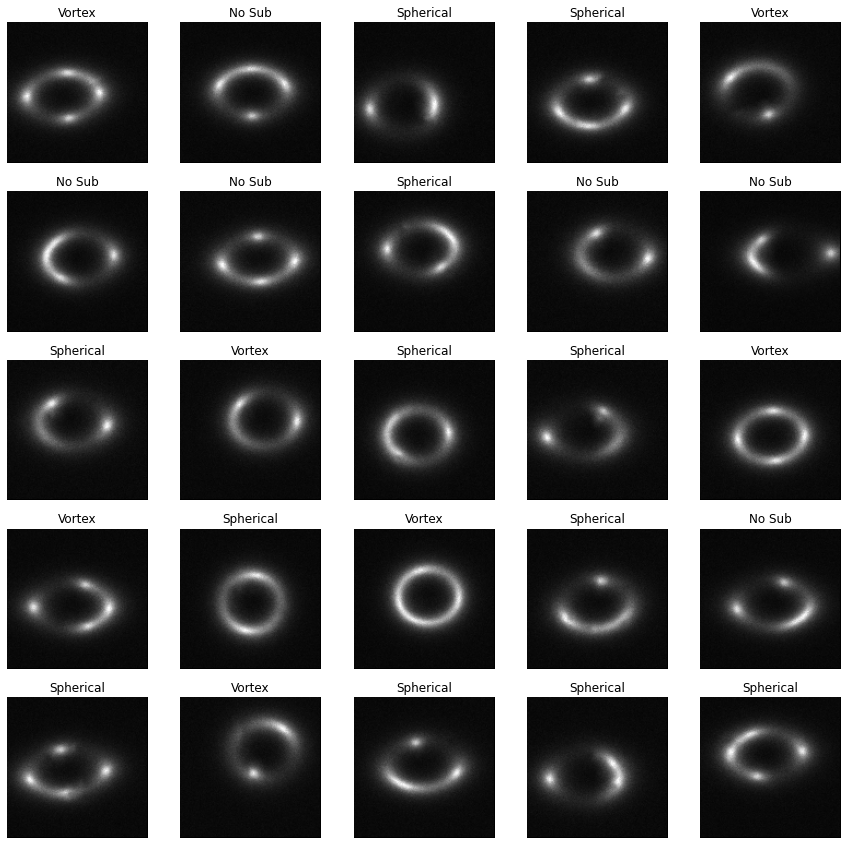

In [12]:
labels_map = {0: 'No Sub',1:'Spherical', 2:'Vortex'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### **The Model Definition**
Since the input images are gray-scale, the input model type will be scalar field. Inside the network, we use regular fields. Finally, group pooling is used to build invariant features. Two fully connected layers perform the final classification.

In [13]:
class Equivariant_Network(torch.nn.Module):
    
    def __init__(self, n_classes=n_classes, sym_group = sym_group, N = N):
        
        super(Equivariant_Network, self).__init__()
        
        # Dihyderal Equivariance
        if sym_group == 'Dihyderal':
            self.r2_act = gspaces.FlipRot2dOnR2(N=N)

        # Circular Equivariance
        elif sym_group == 'Circular':
            self.r2_act = gspaces.Rot2dOnR2(N=N)

        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 129, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = nn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(43264, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x
    

#### __Model Initialization__

In [14]:
model = Equivariant_Network(n_classes=n_classes, sym_group = sym_group, N =N).to(device)

#### __Define training setup__

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epochs = epochs
log_interval = 100  #Intervals after which results are displayed

## __Training__

In [16]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(total_epochs):
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    total = 0
    correct = 0
    for i, (x, t) in enumerate(train_loader):        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)
        y_pred = y.flatten().to(torch.float64)
        
        _, prediction = torch.max(y.data, 1)
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        loss = loss_function(y, t)
        tr_loss_epoch.append(loss.item())
        if i % log_interval == 0:
            print('Loss: ',loss.item())
        loss.backward()

        optimizer.step()
      
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    
    
    if epoch % 1 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(test_loader):
                x = x.to(device)
                t = t.to(device)
                y = model(x)
                
                loss = loss_function(y, t)
                test_loss_epoch.append(loss.item())

                _, prediction = torch.max(y.data, 1)
                total += t.shape[0]
                correct += (prediction == t).sum().item()
                
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
        logging.debug("epoch {} | test accuracy: {}".format(epoch,correct/total*100))
        
        test_accuracy = correct/total*100
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = copy.deepcopy(model)    

all_epochs = [i for i in range (total_epochs)]

all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

Loss:  1.2114145755767822
Loss:  1.1291911602020264
Loss:  1.105745792388916
Loss:  1.0970491170883179
Loss:  1.0655783414840698
Loss:  1.0812593698501587
Loss:  0.9098544120788574
Loss:  0.9436423778533936
Loss:  0.7801536321640015
Loss:  0.7519479990005493
Loss:  0.5989367961883545
Loss:  0.5499384999275208


DEBUG:root:epoch 0 | test accuracy: 51.77333333333334


Loss:  0.4622728228569031
Loss:  0.6357739567756653
Loss:  0.49966248869895935
Loss:  0.3541091978549957
Loss:  0.33754661679267883
Loss:  0.3263118863105774
Loss:  0.2624828517436981
Loss:  0.36988404393196106
Loss:  0.1980385035276413
Loss:  0.33572396636009216
Loss:  0.21214687824249268
Loss:  0.34414243698120117


DEBUG:root:epoch 1 | test accuracy: 62.08


Loss:  0.18649479746818542
Loss:  0.22334735095500946
Loss:  0.1953781545162201
Loss:  0.23836177587509155
Loss:  0.23338401317596436
Loss:  0.2005545198917389
Loss:  0.18817642331123352
Loss:  0.09928520768880844
Loss:  0.21235795319080353
Loss:  0.1993858814239502
Loss:  0.1453271061182022
Loss:  0.11805731803178787


DEBUG:root:epoch 2 | test accuracy: 81.12


Loss:  0.1836339831352234
Loss:  0.21669892966747284
Loss:  0.2829737365245819
Loss:  0.1453072875738144
Loss:  0.1577703058719635
Loss:  0.19157004356384277
Loss:  0.1106807142496109
Loss:  0.08720274269580841
Loss:  0.075453981757164
Loss:  0.05535391718149185
Loss:  0.10639723390340805
Loss:  0.13628357648849487


DEBUG:root:epoch 3 | test accuracy: 76.89333333333333


Loss:  0.11181377619504929
Loss:  0.08963288366794586
Loss:  0.13199320435523987
Loss:  0.19097065925598145
Loss:  0.05611206218600273
Loss:  0.18240760266780853
Loss:  0.12510530650615692
Loss:  0.12810005247592926
Loss:  0.21103081107139587
Loss:  0.08532886207103729
Loss:  0.13438357412815094
Loss:  0.08318755030632019


DEBUG:root:epoch 4 | test accuracy: 88.61333333333333


Loss:  0.26838138699531555
Loss:  0.15486131608486176
Loss:  0.08200537413358688
Loss:  0.22039222717285156
Loss:  0.0858442634344101
Loss:  0.2244032770395279
Loss:  0.11884116381406784
Loss:  0.0649118572473526
Loss:  0.04382513463497162
Loss:  0.08388074487447739
Loss:  0.12253677845001221
Loss:  0.059023287147283554


DEBUG:root:epoch 5 | test accuracy: 71.57333333333334


Loss:  0.11556432396173477
Loss:  0.10338004678487778
Loss:  0.05978833884000778
Loss:  0.06913599371910095
Loss:  0.047811370342969894
Loss:  0.04600561782717705
Loss:  0.1579606980085373
Loss:  0.11948680132627487
Loss:  0.05048629641532898
Loss:  0.152040496468544
Loss:  0.14583809673786163
Loss:  0.07248960435390472


DEBUG:root:epoch 6 | test accuracy: 90.03999999999999


Loss:  0.1907404065132141
Loss:  0.06297298520803452
Loss:  0.14898021519184113
Loss:  0.22656971216201782
Loss:  0.13059766590595245
Loss:  0.0983339175581932
Loss:  0.06828749924898148
Loss:  0.1426635980606079
Loss:  0.1101154088973999
Loss:  0.20642048120498657
Loss:  0.03691701591014862
Loss:  0.020275834947824478


DEBUG:root:epoch 7 | test accuracy: 88.65333333333332


Loss:  0.04415608569979668
Loss:  0.06597938388586044
Loss:  0.03249145671725273
Loss:  0.12427478283643723
Loss:  0.15282687544822693
Loss:  0.12716734409332275
Loss:  0.05145879089832306
Loss:  0.03176861256361008
Loss:  0.048608895391225815
Loss:  0.07347086071968079
Loss:  0.16200530529022217
Loss:  0.06657460331916809


DEBUG:root:epoch 8 | test accuracy: 83.06666666666666


Loss:  0.18602897226810455
Loss:  0.09836817532777786
Loss:  0.1021343544125557
Loss:  0.07561103254556656
Loss:  0.14397135376930237
Loss:  0.11432546377182007
Loss:  0.1349768340587616
Loss:  0.05568874999880791
Loss:  0.03174004703760147
Loss:  0.12429826706647873
Loss:  0.1290503889322281
Loss:  0.09313015639781952


DEBUG:root:epoch 9 | test accuracy: 89.73333333333333


Loss:  0.05307600274682045
Loss:  0.05705491080880165
Loss:  0.0888587087392807
Loss:  0.1190909817814827
Loss:  0.039390794932842255
Loss:  0.03952575847506523
Loss:  0.08709368854761124
Loss:  0.14480973780155182
Loss:  0.07697783410549164
Loss:  0.07501198351383209
Loss:  0.09069705009460449
Loss:  0.08586006611585617


DEBUG:root:epoch 10 | test accuracy: 81.73333333333333


Loss:  0.1260649412870407
Loss:  0.05124463513493538
Loss:  0.08835679292678833
Loss:  0.025224218145012856
Loss:  0.030638953670859337
Loss:  0.02213595062494278
Loss:  0.05164504796266556
Loss:  0.08442385494709015
Loss:  0.039932698011398315
Loss:  0.08316412568092346
Loss:  0.051992662250995636
Loss:  0.03880046308040619


DEBUG:root:epoch 11 | test accuracy: 88.36


Loss:  0.05325401574373245
Loss:  0.028333891183137894
Loss:  0.027621334418654442
Loss:  0.08357026427984238
Loss:  0.049069371074438095
Loss:  0.050671353936195374
Loss:  0.04486237093806267
Loss:  0.014812493696808815
Loss:  0.04531366378068924
Loss:  0.015326048247516155
Loss:  0.10511423647403717
Loss:  0.04921557009220123


DEBUG:root:epoch 12 | test accuracy: 91.41333333333334


Loss:  0.08683523535728455
Loss:  0.039431631565093994
Loss:  0.06670308113098145
Loss:  0.07009685784578323
Loss:  0.13080255687236786
Loss:  0.08014911413192749
Loss:  0.02043420448899269
Loss:  0.0330217219889164
Loss:  0.12013028562068939
Loss:  0.04803820326924324
Loss:  0.11643554270267487
Loss:  0.025699922814965248


DEBUG:root:epoch 13 | test accuracy: 89.85333333333332


Loss:  0.13615109026432037
Loss:  0.025465482845902443
Loss:  0.017759304493665695
Loss:  0.15040625631809235
Loss:  0.15575182437896729
Loss:  0.1030116081237793
Loss:  0.04424433782696724
Loss:  0.0655919760465622
Loss:  0.028683900833129883
Loss:  0.055999599397182465
Loss:  0.07325147837400436
Loss:  0.030229929834604263


DEBUG:root:epoch 14 | test accuracy: 71.78666666666666


Loss:  0.06505969166755676
Loss:  0.06474097073078156
Loss:  0.06137211248278618
Loss:  0.10327035188674927
Loss:  0.028558343648910522
Loss:  0.056067537516355515
Loss:  0.04736868664622307
Loss:  0.03839307278394699
Loss:  0.03274748846888542
Loss:  0.1229117289185524
Loss:  0.09418420493602753
Loss:  0.053656261414289474


DEBUG:root:epoch 15 | test accuracy: 84.17333333333333


Loss:  0.09600742906332016
Loss:  0.04673425853252411
Loss:  0.053617022931575775
Loss:  0.0335734523832798
Loss:  0.03531818091869354
Loss:  0.05308277904987335
Loss:  0.03410026803612709
Loss:  0.02138335444033146
Loss:  0.02901841327548027
Loss:  0.05081069841980934
Loss:  0.0993361547589302
Loss:  0.020112810656428337


DEBUG:root:epoch 16 | test accuracy: 94.70666666666666


Loss:  0.04752948135137558
Loss:  0.066465824842453
Loss:  0.02611720934510231
Loss:  0.023866139352321625
Loss:  0.03946944326162338
Loss:  0.005889484658837318
Loss:  0.0694115161895752
Loss:  0.05795809626579285
Loss:  0.009271921589970589
Loss:  0.02443780191242695
Loss:  0.05994890630245209
Loss:  0.13952821493148804


DEBUG:root:epoch 17 | test accuracy: 96.76


Loss:  0.02194279618561268
Loss:  0.10015080124139786
Loss:  0.1417243629693985
Loss:  0.08773792535066605
Loss:  0.03173389285802841
Loss:  0.15136180818080902
Loss:  0.14482612907886505
Loss:  0.022469928488135338
Loss:  0.0717424526810646
Loss:  0.021002154797315598
Loss:  0.10887940973043442
Loss:  0.031226245686411858


DEBUG:root:epoch 18 | test accuracy: 91.86666666666666


Loss:  0.030188584700226784
Loss:  0.08777085691690445
Loss:  0.09973025321960449
Loss:  0.02094028890132904
Loss:  0.017022239044308662
Loss:  0.010921167209744453
Loss:  0.049281731247901917
Loss:  0.058617908507585526
Loss:  0.10285218060016632
Loss:  0.06422159820795059
Loss:  0.1055699959397316
Loss:  0.0877741128206253


DEBUG:root:epoch 19 | test accuracy: 85.32


Loss:  0.021926498040556908
Loss:  0.02371269464492798
Loss:  0.22292286157608032
Loss:  0.012545174919068813
Loss:  0.056161459535360336
Loss:  0.0085908193141222
Loss:  0.04857418313622475
Loss:  0.04089094698429108
Loss:  0.02986207790672779
Loss:  0.08412390202283859
Loss:  0.02897368185222149
Loss:  0.05348121374845505


DEBUG:root:epoch 20 | test accuracy: 97.48


Loss:  0.019551441073417664
Loss:  0.08416491001844406
Loss:  0.053547024726867676
Loss:  0.051462069153785706
Loss:  0.14364470541477203
Loss:  0.08695381879806519
Loss:  0.01673208922147751
Loss:  0.02116994559764862
Loss:  0.03523463383316994
Loss:  0.01195482537150383
Loss:  0.03881023824214935
Loss:  0.10740330815315247


DEBUG:root:epoch 21 | test accuracy: 95.34666666666666


Loss:  0.036819711327552795
Loss:  0.05407589301466942
Loss:  0.01721389964222908
Loss:  0.04790584743022919
Loss:  0.18660558760166168
Loss:  0.16851450502872467
Loss:  0.029100345447659492
Loss:  0.014450497925281525
Loss:  0.18700464069843292
Loss:  0.04173140972852707
Loss:  0.0238790325820446
Loss:  0.034575048834085464


DEBUG:root:epoch 22 | test accuracy: 97.58666666666667


Loss:  0.04932020232081413
Loss:  0.03621351718902588
Loss:  0.17021121084690094
Loss:  0.0240172129124403
Loss:  0.028002364560961723
Loss:  0.01865868829190731
Loss:  0.02728402242064476
Loss:  0.01227292325347662
Loss:  0.14578694105148315
Loss:  0.09641388058662415
Loss:  0.048242777585983276
Loss:  0.011970428749918938


DEBUG:root:epoch 23 | test accuracy: 89.36


Loss:  0.06922437250614166
Loss:  0.03989256173372269
Loss:  0.048961564898490906
Loss:  0.006502509117126465
Loss:  0.010521984659135342
Loss:  0.011163364164531231
Loss:  0.04734165593981743
Loss:  0.017062140628695488
Loss:  0.03811323270201683
Loss:  0.053096920251846313
Loss:  0.015321053564548492
Loss:  0.005340741015970707


DEBUG:root:epoch 24 | test accuracy: 76.75999999999999


Loss:  0.09024500101804733
Loss:  0.04373525455594063
Loss:  0.025199368596076965
Loss:  0.016349397599697113
Loss:  0.03826916962862015
Loss:  0.015648022294044495
Loss:  0.09895025938749313
Loss:  0.010679489001631737
Loss:  0.010918594896793365
Loss:  0.044565822929143906
Loss:  0.016639886423945427
Loss:  0.1211659237742424


DEBUG:root:epoch 25 | test accuracy: 95.97333333333333


Loss:  0.0124001894146204
Loss:  0.04517555609345436
Loss:  0.023501042276620865
Loss:  0.12525980174541473
Loss:  0.01729203201830387
Loss:  0.028616078197956085
Loss:  0.005719523876905441
Loss:  0.014663532376289368
Loss:  0.06257570534944534
Loss:  0.008964486420154572
Loss:  0.043379537761211395
Loss:  0.006550673395395279


DEBUG:root:epoch 26 | test accuracy: 96.37333333333333


Loss:  0.06442543864250183
Loss:  0.0632983148097992
Loss:  0.005965328309684992
Loss:  0.019130775704979897
Loss:  0.20981964468955994
Loss:  0.08360312134027481
Loss:  0.12552684545516968
Loss:  0.03128743916749954
Loss:  0.04389214515686035
Loss:  0.021851692348718643
Loss:  0.028190722689032555
Loss:  0.09813711792230606


DEBUG:root:epoch 27 | test accuracy: 97.85333333333334


Loss:  0.02071266621351242
Loss:  0.035621825605630875
Loss:  0.09209313988685608
Loss:  0.012269522994756699
Loss:  0.04203563183546066
Loss:  0.010938904248178005
Loss:  0.1472783237695694
Loss:  0.08364367485046387
Loss:  0.008306740783154964
Loss:  0.10732767730951309
Loss:  0.047598548233509064
Loss:  0.006102978717535734


DEBUG:root:epoch 28 | test accuracy: 97.62666666666667


Loss:  0.019170548766851425
Loss:  0.018291383981704712
Loss:  0.03466657176613808
Loss:  0.027305344119668007
Loss:  0.11363133788108826
Loss:  0.03179417550563812
Loss:  0.07078428566455841
Loss:  0.05000917986035347
Loss:  0.01468880195170641
Loss:  0.03408295661211014
Loss:  0.022130634635686874
Loss:  0.006781710311770439


DEBUG:root:epoch 29 | test accuracy: 91.37333333333333


Loss:  0.09105651080608368
Loss:  0.08216509222984314
Loss:  0.0046393489465117455
Loss:  0.008236663416028023
Loss:  0.076043039560318
Loss:  0.11663546413183212
Loss:  0.041384946554899216
Loss:  0.04574882611632347
Loss:  0.02294313721358776
Loss:  0.025475947186350822
Loss:  0.11006640642881393
Loss:  0.02287290059030056


DEBUG:root:epoch 30 | test accuracy: 94.19999999999999


Loss:  0.023024270310997963
Loss:  0.015850692987442017
Loss:  0.03935832530260086
Loss:  0.009315172210335732
Loss:  0.12476518750190735
Loss:  0.08278422802686691
Loss:  0.01383247785270214
Loss:  0.013390754349529743
Loss:  0.008998545818030834
Loss:  0.0747886374592781
Loss:  0.01660005748271942
Loss:  0.014032230712473392


DEBUG:root:epoch 31 | test accuracy: 91.0


Loss:  0.006662775296717882
Loss:  0.12516136467456818
Loss:  0.014640633016824722
Loss:  0.03537428379058838
Loss:  0.012345939874649048
Loss:  0.0014826836995780468
Loss:  0.02295623905956745
Loss:  0.03212224692106247
Loss:  0.01764153316617012
Loss:  0.0233004093170166
Loss:  0.018051836639642715
Loss:  0.09443926066160202


DEBUG:root:epoch 32 | test accuracy: 95.89333333333333


Loss:  0.024804038926959038
Loss:  0.07400500774383545
Loss:  0.0041032517328858376
Loss:  0.021719885990023613
Loss:  0.01222501415759325
Loss:  0.02525893785059452
Loss:  0.018047068268060684
Loss:  0.01964302733540535
Loss:  0.023184670135378838
Loss:  0.07282558083534241
Loss:  0.018151752650737762
Loss:  0.02900289185345173


DEBUG:root:epoch 33 | test accuracy: 85.01333333333334


Loss:  0.01766851544380188
Loss:  0.038891322910785675
Loss:  0.016318783164024353
Loss:  0.039804767817258835
Loss:  0.03180086240172386
Loss:  0.09039277583360672
Loss:  0.011931909248232841
Loss:  0.03570886328816414
Loss:  0.038408856838941574
Loss:  0.04769201576709747
Loss:  0.10773449391126633
Loss:  0.044421516358852386


DEBUG:root:epoch 34 | test accuracy: 98.34666666666666


Loss:  0.04091395437717438
Loss:  0.0353156253695488
Loss:  0.11736071854829788
Loss:  0.022448968142271042
Loss:  0.06564071774482727
Loss:  0.07862581312656403
Loss:  0.011684119701385498
Loss:  0.022309189662337303
Loss:  0.09087708592414856
Loss:  0.02576042152941227
Loss:  0.02368580922484398
Loss:  0.027890510857105255


DEBUG:root:epoch 35 | test accuracy: 97.64


Loss:  0.04599720984697342
Loss:  0.009080329909920692
Loss:  0.03348149359226227
Loss:  0.03885902464389801
Loss:  0.007036274764686823
Loss:  0.029524529352784157
Loss:  0.13702793419361115
Loss:  0.010387149639427662
Loss:  0.04308144748210907
Loss:  0.028404293581843376
Loss:  0.025139745324850082
Loss:  0.06475222855806351


DEBUG:root:epoch 36 | test accuracy: 91.58666666666667


Loss:  0.0056360745802521706
Loss:  0.039979878813028336
Loss:  0.024301370605826378
Loss:  0.0005139917484484613
Loss:  0.01366354152560234
Loss:  0.03750377148389816
Loss:  0.02272065542638302
Loss:  0.03366552293300629
Loss:  0.015806779265403748
Loss:  0.009198565967381
Loss:  0.025609858334064484
Loss:  0.040093209594488144


DEBUG:root:epoch 37 | test accuracy: 83.64


Loss:  0.0729924887418747
Loss:  0.025762958452105522
Loss:  0.007479147985577583
Loss:  0.011776676401495934
Loss:  0.04798988625407219
Loss:  0.004516782239079475
Loss:  0.08818168938159943
Loss:  0.015615765936672688
Loss:  0.05766403302550316
Loss:  0.023498987779021263
Loss:  0.011107709258794785
Loss:  0.03599078580737114


DEBUG:root:epoch 38 | test accuracy: 98.6


Loss:  0.002980147022753954
Loss:  0.02391938678920269
Loss:  0.024509379640221596
Loss:  0.03868267685174942
Loss:  0.03383583575487137
Loss:  0.06425019353628159
Loss:  0.029812807217240334
Loss:  0.006125928834080696
Loss:  0.0339602530002594
Loss:  0.004595405422151089
Loss:  0.010882028378546238
Loss:  0.007587161846458912


DEBUG:root:epoch 39 | test accuracy: 83.16


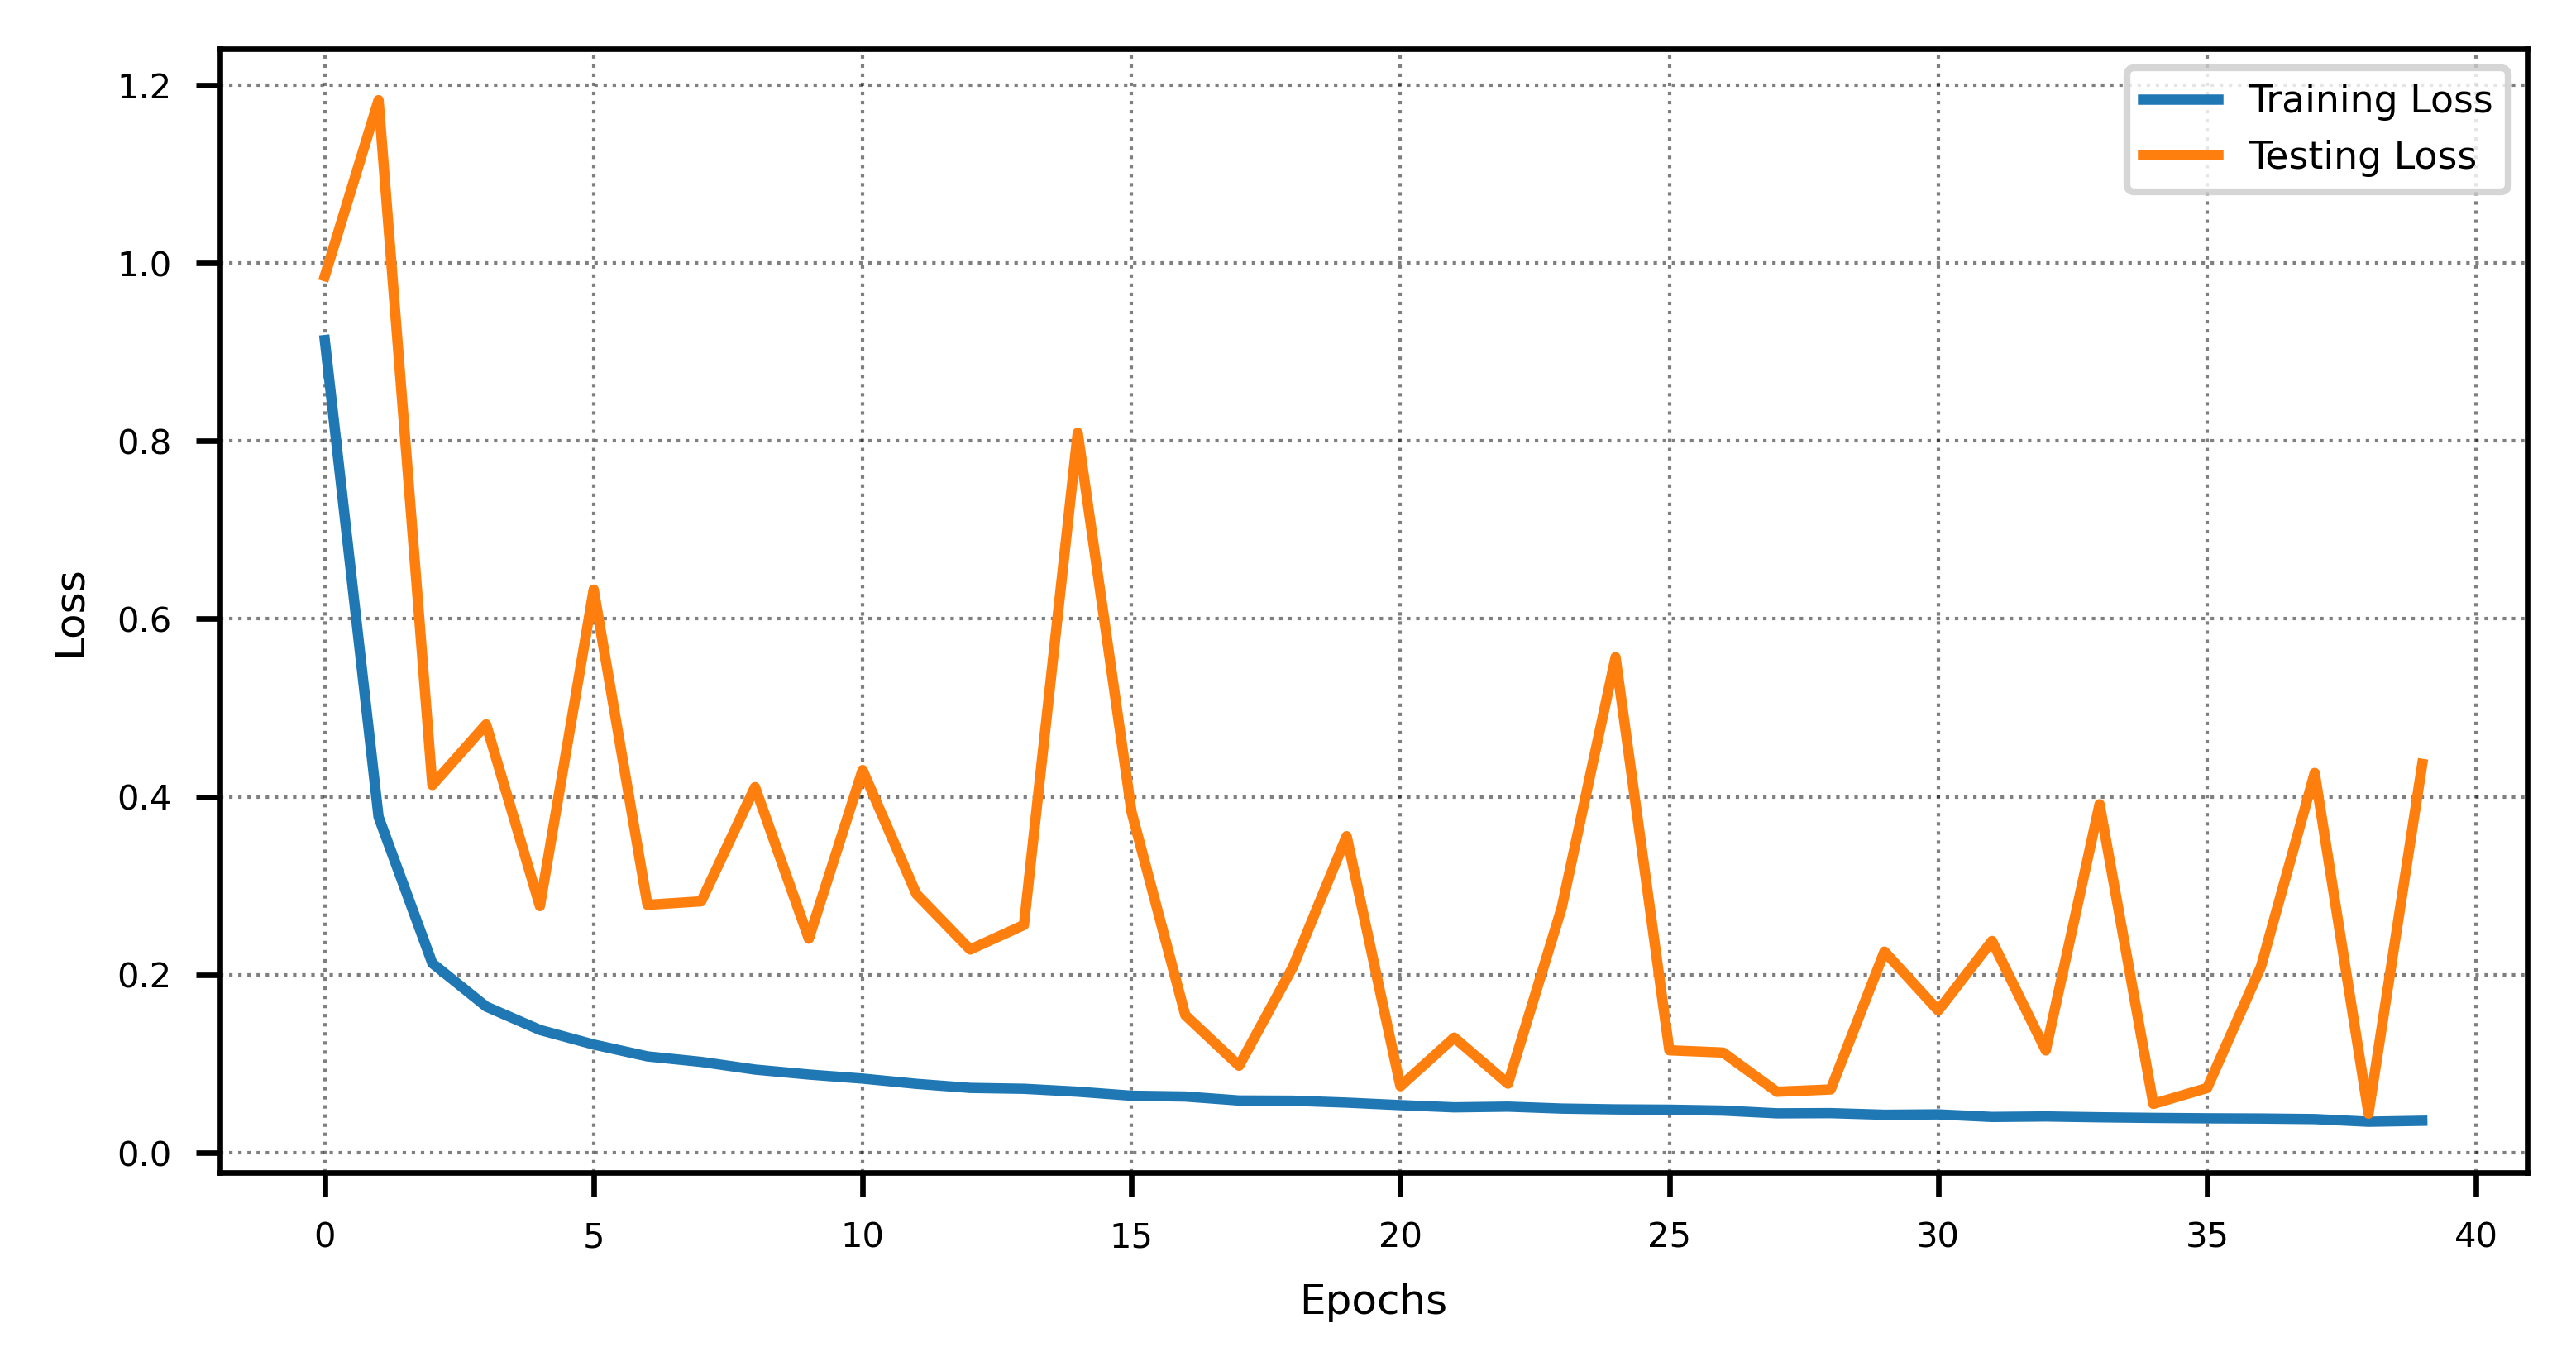

In [17]:
params_mat = {'legend.fontsize': 5.5,
          'axes.labelsize': 6,
          'axes.titlesize': 5,
          'xtick.labelsize': 5,
          'ytick.labelsize': 5,
          'axes.titlepad': 25}
plt.rcParams.update(params_mat)

fig = plt.figure(figsize=(6, 3), dpi=600)


plt.grid(color='black', linestyle='dotted', linewidth=.5, alpha = 0.5)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(all_epochs, all_train_loss_mean, label="Training Loss")
plt.plot(all_epochs, all_test_loss_mean, label="Testing Loss")
plt.legend()
plt.show()

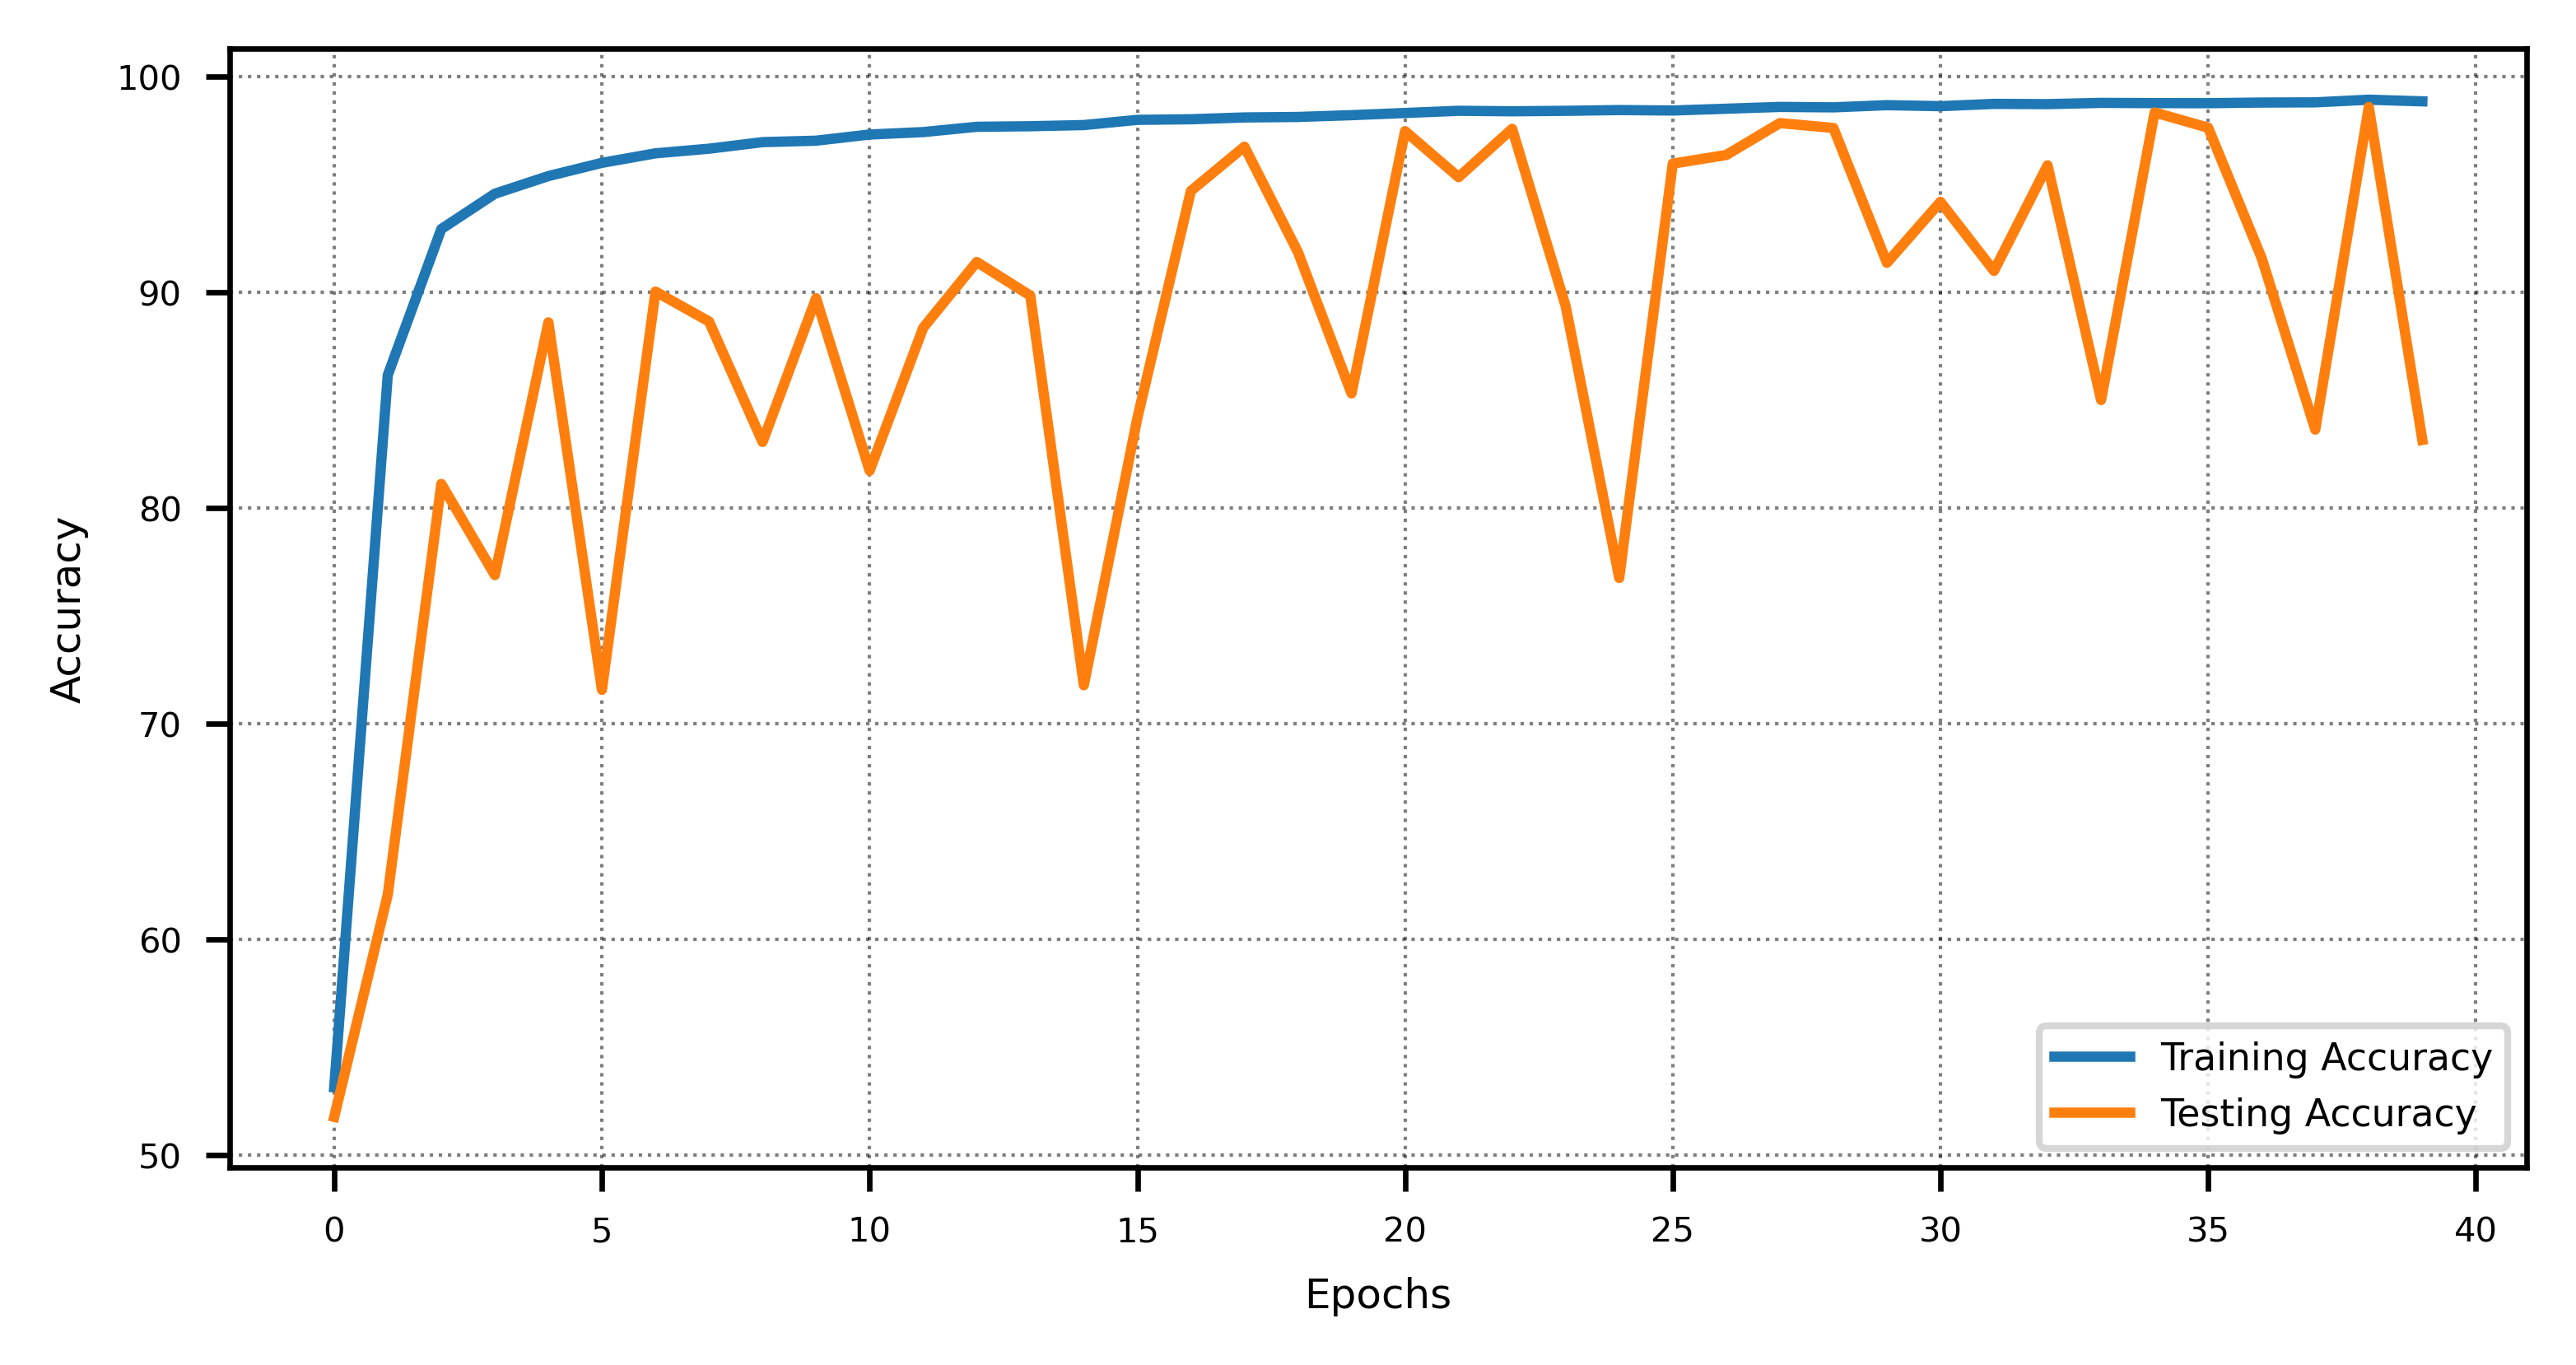

In [18]:
params_mat = {'legend.fontsize': 5.5,
          'axes.labelsize': 6,
          'axes.titlesize': 5,
          'xtick.labelsize': 5,
          'ytick.labelsize': 5,
          'axes.titlepad': 25}
plt.rcParams.update(params_mat)

fig = plt.figure(figsize=(6, 3), dpi=600)

plt.grid(color='black', linestyle='dotted', linewidth=.5, alpha = 0.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(all_epochs, all_train_accuracy, label="Training Accuracy")
plt.plot(all_epochs, all_test_accuracy, label="Testing Accuracy")
plt.legend()
plt.show()

#### __Evaluation__

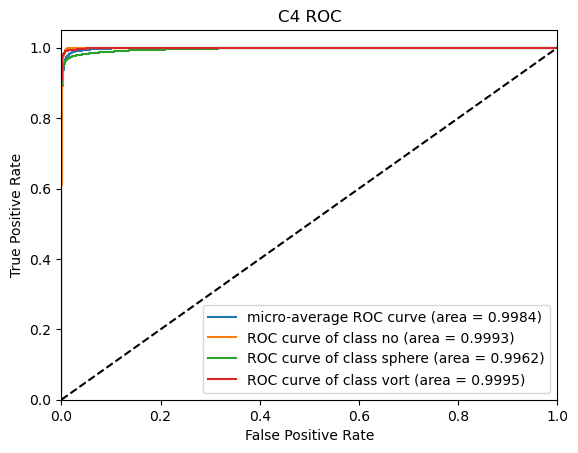

In [19]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(test_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(3,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in testset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(sym_group[0]+str(N)+' ROC')
plt.legend(loc="lower right")
plt.show()

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b49afc79490>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b49afc79490> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


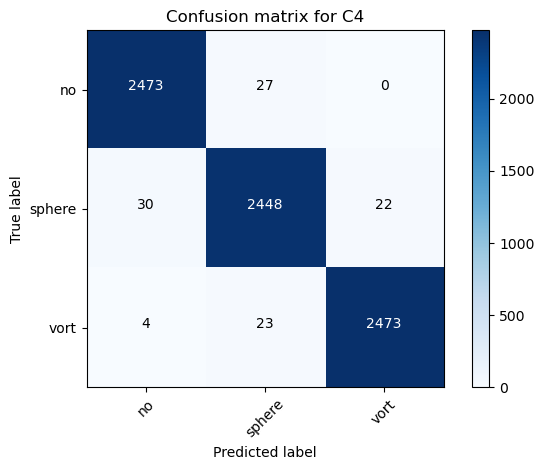

In [21]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1], inv_map[2]],title='Confusion matrix for '+sym_group[0]+str(N))